In [23]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.8/906.8 kB 15.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [24]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import pandas as pd
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [25]:
annotations_dir = '/kaggle/input/face-mask-detection/annotations'
images_dir = '/kaggle/input/face-mask-detection/images'
output_dir = '/kaggle/working/dataset'
os.makedirs(f"{output_dir}/images", exist_ok=True)
os.makedirs(f"{output_dir}/labels", exist_ok=True)

class_map = {"with_mask": 0, "without_mask": 1}

In [26]:
def convert_xml_to_yolo(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    image_filename = root.find('filename').text
    image_path = os.path.join(images_dir, image_filename)
    if not os.path.exists(image_path):
        return
    img = Image.open(image_path)
    img_width, img_height = img.size
    yolo_label = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name not in class_map:
            continue
        class_id = class_map[class_name]
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height
        yolo_label.append(f"{class_id} {x_center} {y_center} {width} {height}")
        
    label_filename = os.path.splitext(image_filename)[0]
    with open(f"{output_dir}/labels/{label_filename}.txt", 'w') as f:
        f.write("\n".join(yolo_label))
    img.save(f"{output_dir}/images/{image_filename}")

In [27]:
for xml_file in os.listdir(annotations_dir):
    if xml_file.endswith('.xml'):
        convert_xml_to_yolo(os.path.join(annotations_dir, xml_file))

In [28]:
yaml_content = """
path: /kaggle/working/dataset
train: images
val: images
names:
  0: with_mask
  1: without_mask
"""
with open("/kaggle/working/dataset/data.yaml", "w") as f:
    f.write(yaml_content)

In [29]:
model = YOLO('yolov8s.pt') #pt for pretrained

100%|██████████| 21.5M/21.5M [00:00<00:00, 192MB/s]


In [30]:
model.train(data='/kaggle/working/dataset/data.yaml', epochs=10, imgsz=640)

Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.1MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/labels... 853 images, 21 backgrounds, 0 corrupt: 100%|██████████| 853/853 [00:00<00:00, 881.80it/s]

train: New cache created: /kaggle/working/dataset/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/dataset/labels.cache... 853 images, 21 backgrounds, 0 corrupt: 100%|██████████| 853/853 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.26G      1.646      2.137      1.388          6        640: 100%|██████████| 54/54 [00:16<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.26it/s]

                   all        853       3949      0.762      0.573      0.653      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.35G      1.276     0.9473      1.103         12        640: 100%|██████████| 54/54 [00:13<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.14it/s]


                   all        853       3949      0.799      0.637      0.716      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.48G      1.276     0.9127      1.116         96        640: 100%|██████████| 54/54 [00:13<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.18it/s]


                   all        853       3949      0.857      0.746      0.825      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.48G      1.217     0.8368      1.086         13        640: 100%|██████████| 54/54 [00:14<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.11it/s]


                   all        853       3949      0.833       0.71      0.807      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.28G       1.18     0.7354      1.073         16        640: 100%|██████████| 54/54 [00:14<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.01it/s]


                   all        853       3949      0.849      0.756      0.814      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.13G      1.142     0.6811      1.054         30        640: 100%|██████████| 54/54 [00:14<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.11it/s]

                   all        853       3949       0.88      0.813      0.878      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.16G      1.132     0.6498      1.035         58        640: 100%|██████████| 54/54 [00:14<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.08it/s]

                   all        853       3949      0.884      0.813      0.891      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.48G      1.094     0.6288      1.038         23        640: 100%|██████████| 54/54 [00:15<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  3.89it/s]


                   all        853       3949      0.903      0.853      0.912      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.28G      1.075     0.5855      1.022         13        640: 100%|██████████| 54/54 [00:15<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.03it/s]

                   all        853       3949      0.895      0.852      0.912      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.23G      1.057     0.5578      1.011          6        640: 100%|██████████| 54/54 [00:15<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  3.96it/s]

                   all        853       3949      0.915      0.869      0.929       0.65



10 epochs completed in 0.064 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]


                   all        853       3949      0.914       0.87      0.929       0.65
             with_mask        768       3232      0.947      0.912      0.964      0.704
          without_mask        286        717      0.881      0.827      0.895      0.597
Speed: 0.1ms preprocess, 3.5ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x799755ab6bf0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [31]:
import random
from PIL import Image
import matplotlib.pyplot as plt

In [32]:
def plot_random_predictions(images_dir, model, num_images=3):
    # Select multiple random images from the specified directory
    image_files = random.sample([f for f in os.listdir(images_dir) if f.endswith('.png') or f.endswith('.jpg')], num_images)
    
    # Set up the plot with subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(images_dir, image_file)
        
        # Load the image and make a prediction
        results = model.predict(source=image_path)
        
        # Plot the image with predictions
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        
        # Extract and plot bounding boxes and labels
        for box in results[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()  # Bounding box coordinates
            cls = int(box.cls[0])  # Class ID
            confidence = box.conf[0].item()  # Confidence score
            
            # Draw the bounding box
            axes[i].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', linewidth=2, fill=False))
            
            # Add class label and confidence
            label = f"{model.names[cls]}: {confidence:.2f}"
            axes[i].text(x1, y1, label, color='white', fontsize=12, backgroundcolor='red')
    
    plt.tight_layout()
    plt.show()


image 1/1 /kaggle/working/dataset/images/maksssksksss755.png: 384x640 7 with_masks, 51.4ms
Speed: 2.0ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/working/dataset/images/maksssksksss571.png: 640x512 1 without_mask, 49.7ms
Speed: 2.5ms preprocess, 49.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /kaggle/working/dataset/images/maksssksksss128.png: 640x512 1 without_mask, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


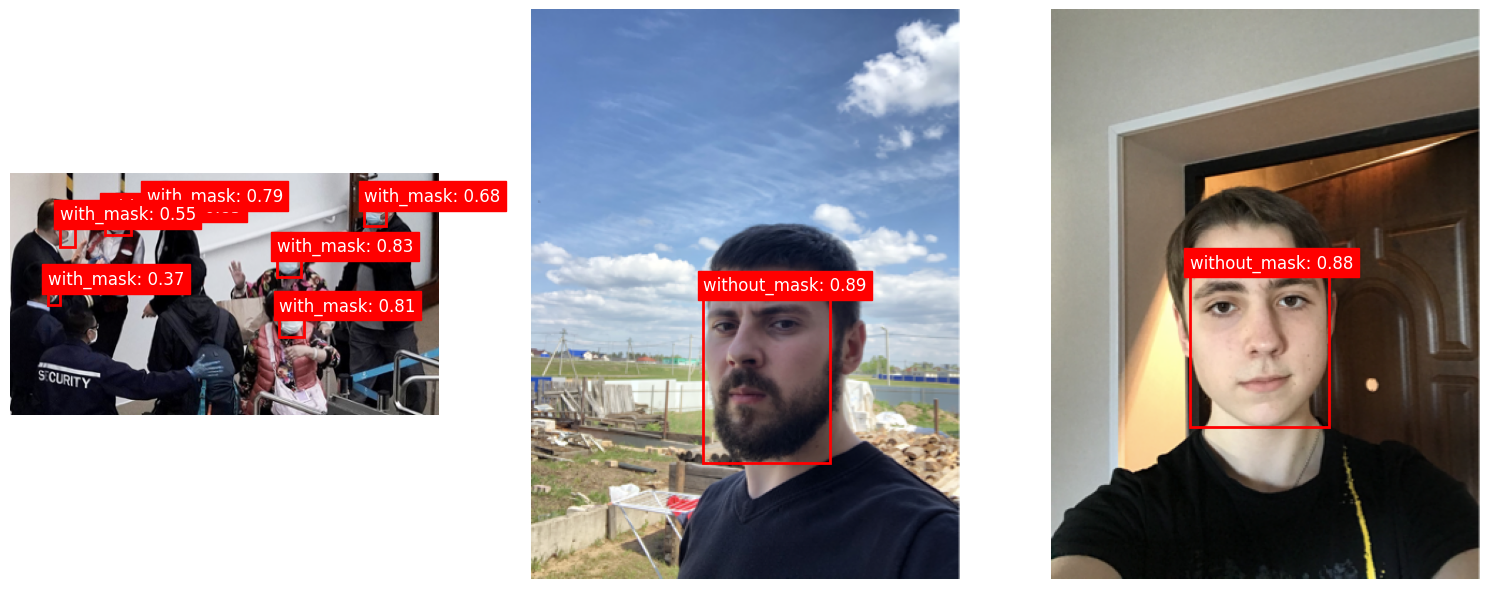

In [33]:
plot_random_predictions('/kaggle/working/dataset/images', model)

In [34]:
ls runs/detect/train

args.yaml                                         results.png
confusion_matrix_normalized.png                   train_batch0.jpg
confusion_matrix.png                              train_batch1.jpg
events.out.tfevents.1736583609.e28060e28769.21.0  train_batch2.jpg
F1_curve.png                                      val_batch0_labels.jpg
labels_correlogram.jpg                            val_batch0_pred.jpg
labels.jpg                                        val_batch1_labels.jpg
P_curve.png                                       val_batch1_pred.jpg
PR_curve.png                                      val_batch2_labels.jpg
R_curve.png                                       val_batch2_pred.jpg
results.csv                                       weights/


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


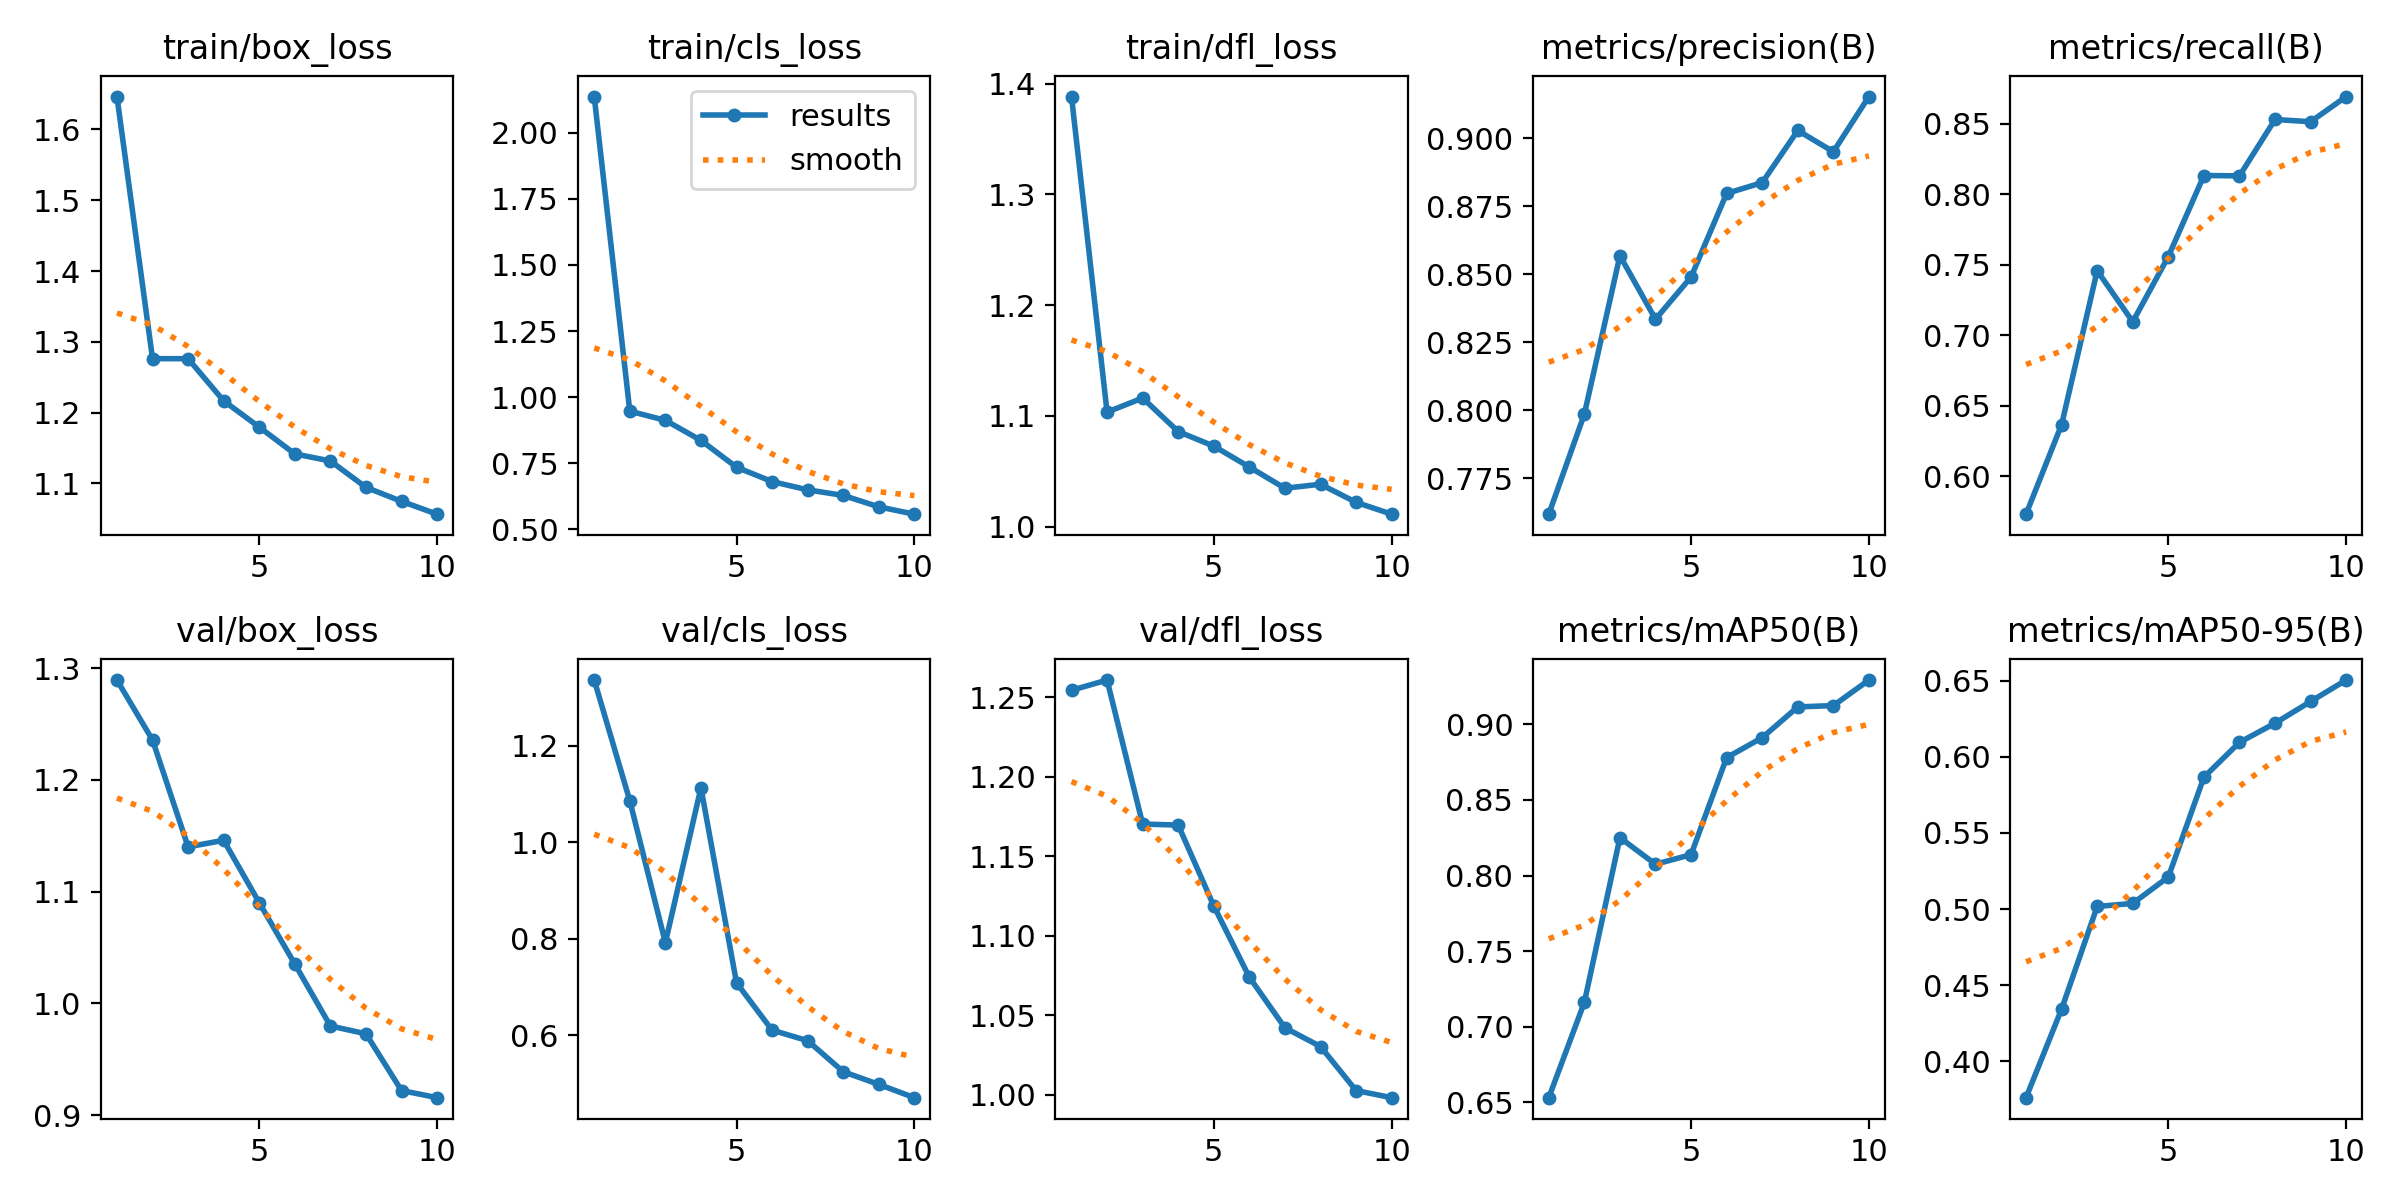

In [35]:
Image.open('./runs/detect/train/results.png')

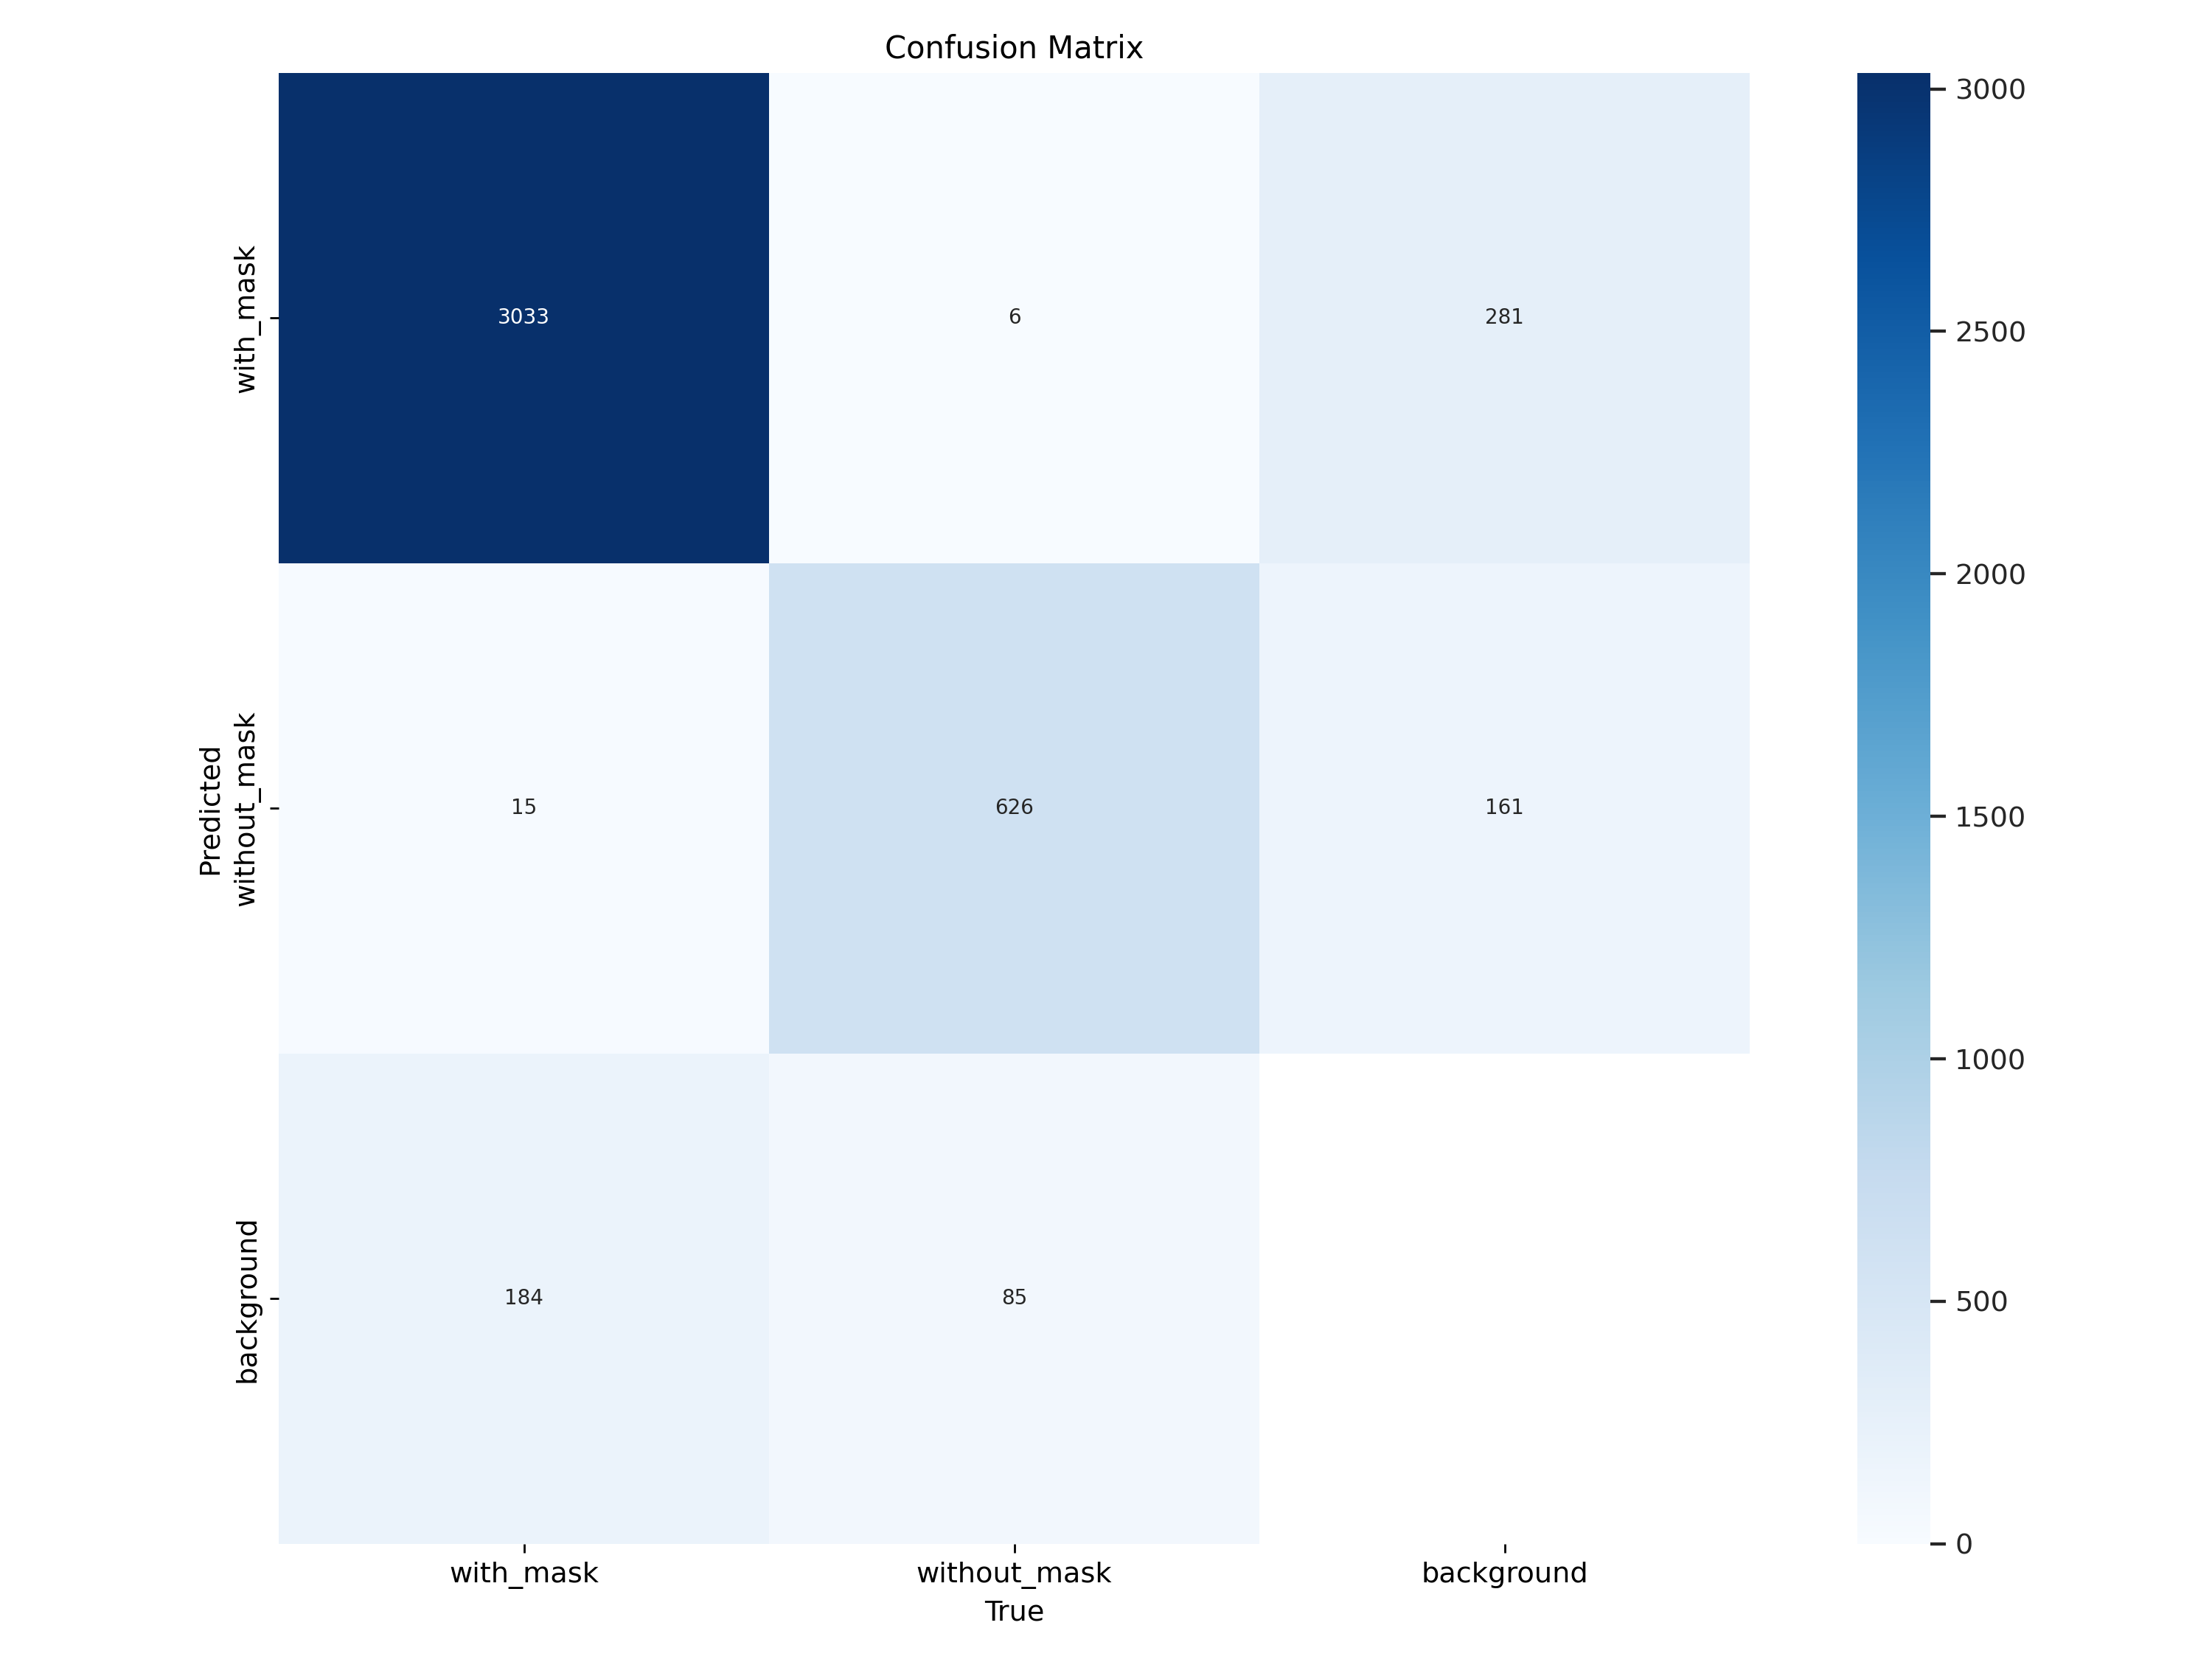

In [36]:
Image.open('./runs/detect/train/confusion_matrix.png')

In [37]:
ls runs/detect/train/weights

best.pt  last.pt


In [38]:
from IPython.display import FileLink 

FileLink(r'/kaggle/working/runs/detect/train/weights/best.pt')

/kaggle/working/runs/detect/train/weights/best.pt

In [39]:
!zip -j best_model.zip runs/detect/train/weights/best.pt

  adding: best.pt (deflated 8%)


In [40]:
ls

best_model.zip  dataset/  __notebook__.ipynb  runs/  yolo11n.pt  yolov8s.pt


In [41]:
FileLink(r'/kaggle/working/best_model.zip')

/kaggle/working/best_model.zip

In [42]:
import torch

In [43]:
torch.save(model.state_dict(), 'saved_best.pt')

In [44]:
ls

best_model.zip  __notebook__.ipynb  saved_best.pt  yolov8s.pt
dataset/        runs/               yolo11n.pt


In [45]:
FileLink(r'/kaggle/working/saved_best.pt')

/kaggle/working/saved_best.pt